<h1> <center> GEOG 172: INTERMEDIATE GEOGRAPHICAL ANALYSIS </h1>
    <h2> <center> Evgeny Noi </h2>
        <h3> <center> Lecture 12: More on Clustering and Clusters </h3>

# Review 

* LISA separates the data into two groups: 
    * local clusters 
    * local outliers 
* Motivating question: *How can we assess spatial patterns in point data?* 
    * Point pattern analysis (centrography, quadrant analysis) 
    * **Clustering** 

# Airbnb Data 

## Amsterdam 

We will download the file from the website you've been working with to access the data for Lab 6. To be able to run the code below, you need to install a Python distribution of wget (e.g. pip install wget). Command 'wget' runs natively on Unix-based systems (e.g. Linux and MacOS), but if you are on Windows, we need to work around it. 

In [1]:
!python -m wget http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2022-09-07/visualisations/listings.csv


Saved under listings (1).csv


In [2]:
!python -m wget http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2022-09-07/visualisations/neighbourhoods.geojson


Saved under neighbourhoods (1).geojson


In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt
import contextily as cx
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [4]:
geo = gpd.read_file('neighbourhoods.geojson') 
print(geo.shape) 
print(geo.crs) 
df = pd.read_csv('listings.csv') 
print(df.shape) 

(22, 3)
epsg:4979
(6893, 18)


In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room,49,3,305,2022-08-30,1.86,1,14,25,0363 5F3A 5684 6750 D14D
1,20168,Studio with private bathroom in the centre 1,59484,Alexander,NaN,Centrum-Oost,52.36407,4.89393,Private room,106,1,339,2020-04-09,2.22,2,0,0,0363 CBB3 2C10 0C2A 1E29
2,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.38761,4.89188,Private room,136,2,231,2022-04-24,1.78,1,121,8,0363 974D 4986 7411 88D8
3,28871,Comfortable double room,124245,Edwin,NaN,Centrum-West,52.36775,4.89092,Private room,75,2,428,2022-08-24,2.92,2,117,75,0363 607B EA74 0BD8 2F6F
4,29051,Comfortable single room,124245,Edwin,NaN,Centrum-Oost,52.36584,4.89111,Private room,55,2,582,2022-08-29,4.16,2,160,86,0363 607B EA74 0BD8 2F6F


In [6]:
# convert pd to gpd 
bnb_pts = gpd.GeoDataFrame(
    df, crs='epsg:4326', geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

coordinates = df[['longitude', 'latitude']].values
random_pattern = random.poisson(coordinates, size=1000)

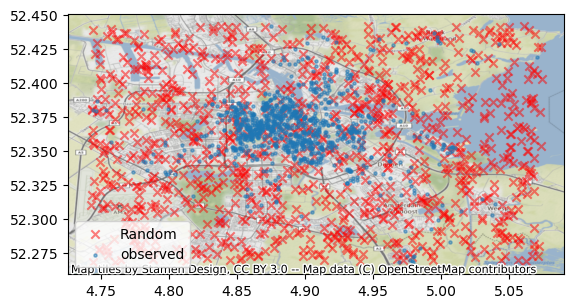

In [7]:
f, ax = plt.subplots()
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random", alpha=.5)
bnb_pts.sample(1000).plot(markersize=5,ax=ax, alpha=.5, label='observed');
cx.add_basemap(ax, crs=bnb_pts.crs.to_string())
ax.legend();

P-value: 0.0


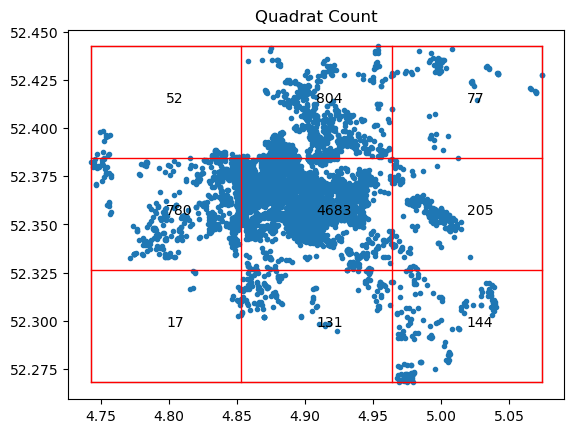

In [8]:
qstat = QStatistic(coordinates)
print('P-value:', qstat.chi2_pvalue)
qstat.plot()

P-value: 0.9541626211623782


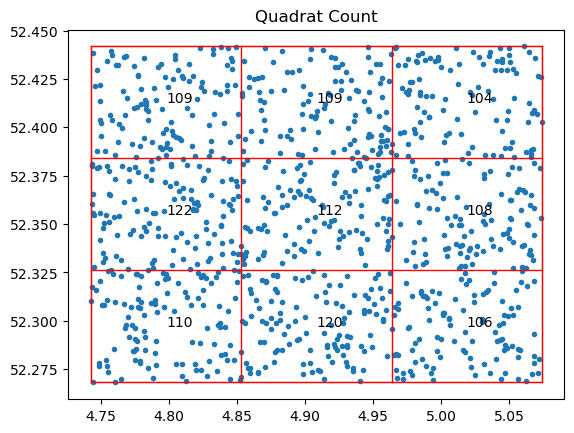

In [9]:
qstat_null = QStatistic(random_pattern)
print('P-value:', qstat_null.chi2_pvalue)
qstat_null.plot()

# Words of Caution with Quadrant Analysis 

* Quadrat counts are measured in a regular tiling that is overlaid on top of the potentially irregular extent of our pattern. Thus, irregular but random patterns can be mistakenly found 'significant'

In [10]:
import libpysal

alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(coordinates, return_circles=True)
random_pattern_ashape = random.poisson(alpha_shape, size=1000)

P-value: 1.7227583237211114e-60


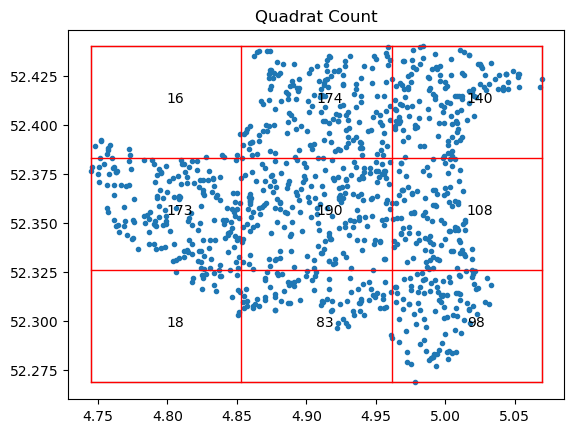

In [11]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
print('P-value:', qstat_null_ashape.chi2_pvalue)
qstat_null_ashape.plot()

# Ripley's Functions 

* Characterize clustering and co-location of point patterns
* Look at nearest neighbor distances between each point and their neighbors at different distance tresholds
* The plot denotes cumulative percentage against the increasing distance radii
* Observed cumulative distribution is compared against a reference (spatially random) distribution (Poisson point process) 

# Ripley's $G$ Function (event-to-event)

$$
G(d) = \sum_{i=1}^n \frac{ \phi_i^d}{n}
$$

$G(d)$ is the proportion of nearest neighbor distances that are less than $d$. 

$$
\phi_i^d =
 \begin{cases}
    1       & \quad \text{if } d_{min}(s_i)<d \\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

In [12]:
# the dataset is large (we need to resample) for computational purposes 
n=500
index = np.random.choice(coordinates.shape[0], n, replace=False)  
print(index.shape)

g_test = distance_statistics.g_test(
    coordinates[index], support=40, keep_simulations=True
)

(500,)


KeyboardInterrupt: 

# Ripley's $G$ intuition 

* Distance **between** points
* In distributions of distances, a **clustered** pattern must have more points near one another than a pattern that is **dispersed**; and a **completely random pattern** should have something in between. 
* If the function increases rapidly with distance, we probably have a clustered pattern. If it increases slowly with distance, we have a dispersed pattern. Something in the middle will be difficult to distinguish from pure chance.

In [13]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    np.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
#ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates[index].T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
f.savefig('Ripley_G.png')
plt.close()

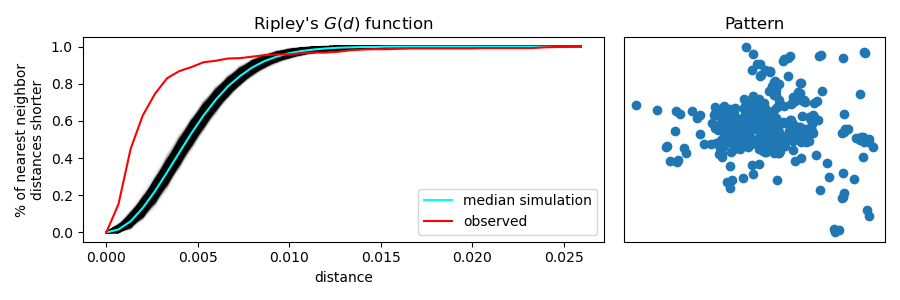

In [14]:
from IPython.display import Image
Image(filename='Ripley_G.png') 

# Ripley's $F$ function (point-event)

* analyzing the distance to points in the pattern from locations in empty space (the 'empty space function') 
* $F$ accumulates, for a growing distance range, the percentage of points that can be found within that range from a random point pattern generated within the extent of the observed pattern
*  If the pattern has large gaps or empty areas, the function will increase slowly. But, if the pattern is highly dispersed, then the function will increase rapidly.

In [15]:
f_test = distance_statistics.f_test(
    coordinates[index], support=40, keep_simulations=True
)

In [16]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    np.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
#ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates[index].T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
f.savefig('Ripley_F.png')
plt.close()

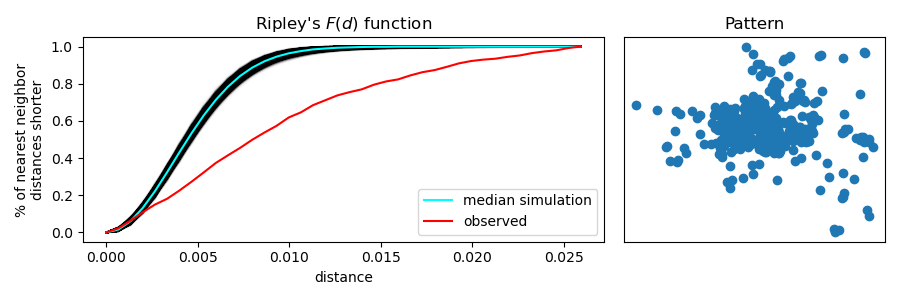

In [17]:
from IPython.display import Image
Image(filename='Ripley_F.png') 

In [40]:
# alternatively 
from pointpats import PointPattern
print(pointpats.__version__)

pp = PointPattern(coordinates[index]) # creates a point pattern plot 
ffun = distance_statistics.F(pp, intervals=15)
gfun = distance_statistics.G(pp, intervals=15)

2.2.0


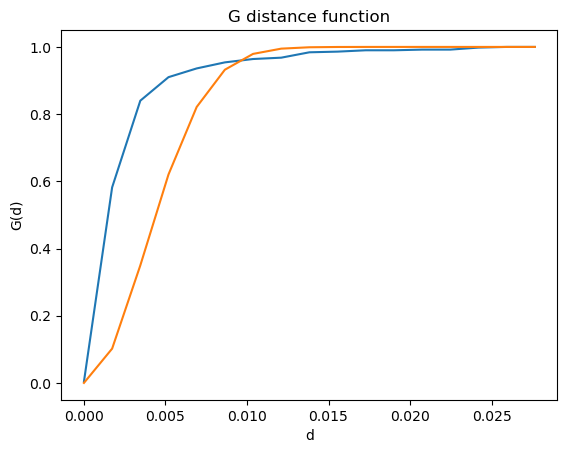

In [35]:
gfun.plot()

# Ripley's $K$ function 

* Considers distance to higher order neighbors (between all pairs of of event points)

$$
K(d) = \frac{\sum_{i=1}^n \sum_{j=1}^n \psi_{ij}(d)}{n \hat{\lambda}}
$$

where

$$
\psi_{ij}(d) =
 \begin{cases}
    1       & \quad \text{if } d_{ij}<d \\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

$\sum \psi_{id}(d)$ is the number of events within a circle of radius d centered on event si 

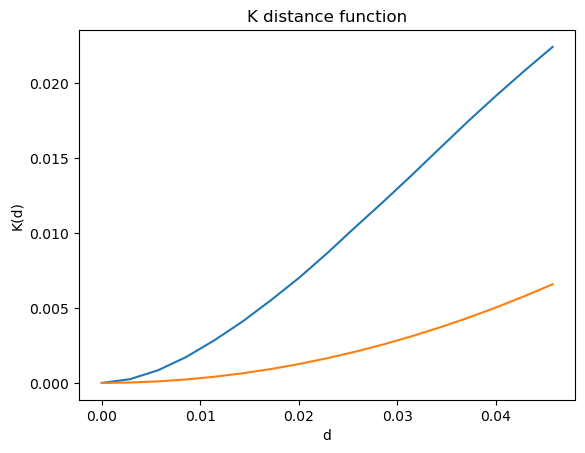

In [42]:
kfun = distance_statistics.K(pp, intervals=15)

kfun.plot()

# Identifying Clusters via Density

* DBSCAN (Density-Based Spatial Clustering of Applications) - algorithm from knowledge discovery and machine learning. 
* DBSCAN is deterministic (there is no associated inferential framework as in LISA). Thus, we cannot relate it to CSR.

# DBSCAN 

* Cluster is a concentration of at least $m$ points, each of them within a distance $r$ of at least another point in cluster (both $m$ and $r$ must be specified by a user).
* DBSCAN patterns: 
    * Noise, for those points outside a cluster.
    * Cores, for those points inside a cluster with at least m points in the cluster within distance r.
    * Borders for points inside a cluster with less than m other points in the cluster within distance r.

<img src="https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png" width="500px">

<img src="https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif">

In [66]:
from sklearn.cluster import DBSCAN

# Define DBSCAN
clusterer = DBSCAN(eps=0.009, min_samples=10)
# Fit to our data
clusterer.fit(df[["longitude", "latitude"]])

DBSCAN(eps=0.009, min_samples=10)

In [67]:
from collections import Counter 
Counter(clusterer.labels_)

Counter({0: 6429,
         1: 149,
         -1: 119,
         7: 27,
         2: 11,
         8: 37,
         3: 40,
         4: 31,
         5: 28,
         6: 11,
         9: 11})

In [86]:
lbls = pd.Series(clusterer.labels_, index=df.index)
categories = np.unique(clusterer.labels_)
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  
df["color"] = lbls.apply(lambda x: colordict[x])

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 7))
# Subset points that are not part of any cluster (noise)
noise = df.loc[lbls == -1, ["longitude", "latitude"]]
# Plot noise in grey
ax.scatter(noise["longitude"], noise["latitude"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    df.loc[df.index.difference(noise.index), "longitude"],
    df.loc[df.index.difference(noise.index), "latitude"],
    c=df.loc[df.index.difference(noise.index), "color"],
    linewidth=0, s=10,
)
# Add basemap
cx.add_basemap(ax, crs=bnb_pts.crs.to_string())
# Remove axes
ax.set_axis_off()
plt.tight_layout()
f.savefig('dbscan.png', bbox_inches='tight', pad_inches=0)
plt.close()

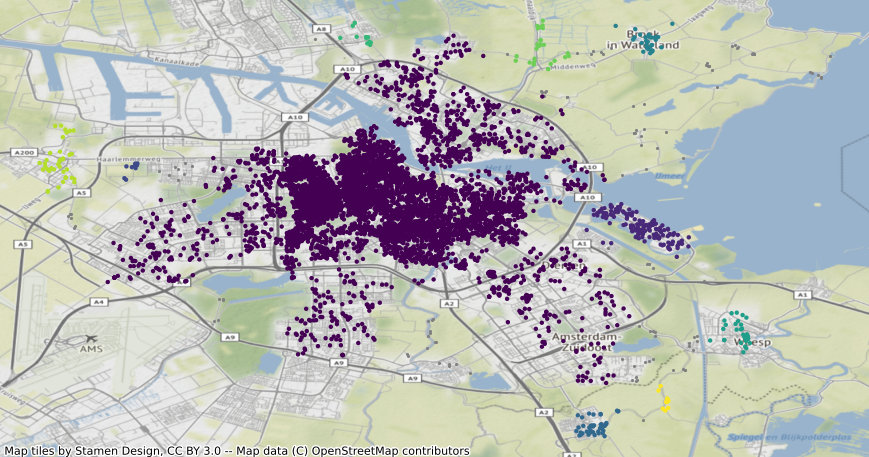

In [87]:
from IPython.display import Image
Image(filename='dbscan.png') 

# Questions? 

# References 

1. https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html
2. https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html#randomness-clustering